In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

pre_trained = "bert-base-german-cased"

### Hyperparameters


In [2]:
epochs = 40
batch_size = 40
drop_out = 0.2

# DataSet

In [3]:
dataset = pd.read_csv('/kaggle/input/discharge-letter/Discharge_letter_dataset.csv')  

In [4]:
possible_labels = dataset.Category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'-': 0, 'MH': 1, 'D': 2, 'TP': 3, 'S': 4, 'DP': 5}

In [5]:
tokenizer = BertTokenizer.from_pretrained(pre_trained, 
                                          do_lower_case=True)
                                          
encoded_data_train = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='train'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    dataset[dataset.data_type=='val'].Text.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(dataset[dataset.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(dataset[dataset.data_type=='val'].label.values)


Downloading:   0%|          | 0.00/249k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Splitting dataset (Train, Test)

In [6]:

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [7]:
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False,
                                                      attention_probs_dropout_prob = drop_out,
                                                      hidden_dropout_prob = drop_out
)
model.cuda()

Downloading:   0%|          | 0.00/419M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Setting model parameters

In [8]:

OverAll_f1 = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

optimizer = AdamW(model.parameters(),lr=1e-5, eps=1e-8)


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Accuracy metric


In [9]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    Accuracy = 0
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        #print(f'Class: {label_dict_inverse[label]}')
        #print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')
        Accuracy += len(y_preds[y_preds==label])/len(y_true)
    return (Accuracy/6)

# Training

In [10]:
import random

train_loss_dict = {}
val_loss_dict = {}
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'/kaggle/working/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    OverAll_f1.append((epoch,val_f1))
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    train_loss_dict[epoch] = loss_train_avg
    val_loss_dict[epoch] = val_loss


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.5868923801642199
Validation loss: 1.3311038613319397
F1 Score (Weighted): 0.4790957186166622


Epoch 2:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.2736541307889497
Validation loss: 1.103317952156067
F1 Score (Weighted): 0.5946815641571269


Epoch 3:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.0602943702385976
Validation loss: 0.9666666388511658
F1 Score (Weighted): 0.6470155616885946


Epoch 4:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.8963619527908472
Validation loss: 0.9410378038883209
F1 Score (Weighted): 0.6812359076605803


Epoch 5:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.7764650629116938
Validation loss: 0.8688332080841065
F1 Score (Weighted): 0.690919692043421


Epoch 6:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.6643482056947855
Validation loss: 0.8871758878231049
F1 Score (Weighted): 0.6773251415241854


Epoch 7:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.5969499475680865
Validation loss: 0.805100417137146
F1 Score (Weighted): 0.718894732810066


Epoch 8:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.5026058319669503
Validation loss: 0.7760592341423035
F1 Score (Weighted): 0.73688409844603


Epoch 9:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.46253648371650624
Validation loss: 0.7785271644592285
F1 Score (Weighted): 0.7355977391109347


Epoch 10:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.3878721014524882
Validation loss: 0.8520915597677231
F1 Score (Weighted): 0.7080198682421913


Epoch 11:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.3549982666109617
Validation loss: 0.8313980281352997
F1 Score (Weighted): 0.732028632665748


Epoch 12:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.3023508871690585
Validation loss: 0.8338139086961747
F1 Score (Weighted): 0.7482713720484521


Epoch 13:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.2741271536797285
Validation loss: 0.8901967331767082
F1 Score (Weighted): 0.7126944558235683


Epoch 14:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.2501019540314491
Validation loss: 0.9165953993797302
F1 Score (Weighted): 0.7276302259958228


Epoch 15:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.23291479459462258
Validation loss: 0.909382713958621
F1 Score (Weighted): 0.7381714891937573


Epoch 16:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.19938164619872203
Validation loss: 0.9421341821551323
F1 Score (Weighted): 0.7254815178442088


Epoch 17:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.17595611082819793
Validation loss: 0.9814326256513596
F1 Score (Weighted): 0.7195161934481282


Epoch 18:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.16049269486505252
Validation loss: 0.9673404894769192
F1 Score (Weighted): 0.7293580862976167


Epoch 19:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.1521070969577592
Validation loss: 0.9990313865244389
F1 Score (Weighted): 0.7412127519751891


Epoch 20:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.14006793284072325
Validation loss: 1.026900913566351
F1 Score (Weighted): 0.739310069323556


Epoch 21:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 21
Training loss: 0.1381109957672799
Validation loss: 1.053703698515892
F1 Score (Weighted): 0.733270279679545


Epoch 22:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 22
Training loss: 0.13383996013838512
Validation loss: 1.0626369386911392
F1 Score (Weighted): 0.7356376399045925


Epoch 23:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 23
Training loss: 0.11401318448882264
Validation loss: 1.0638134324923159
F1 Score (Weighted): 0.7370272287485822


Epoch 24:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 24
Training loss: 0.12217683878798898
Validation loss: 1.0788881212472916
F1 Score (Weighted): 0.7471617481996169


Epoch 25:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 25
Training loss: 0.10203881647724372
Validation loss: 1.0957448065280915
F1 Score (Weighted): 0.7383395947118702


Epoch 26:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 26
Training loss: 0.10582695303198236
Validation loss: 1.0979892954230308
F1 Score (Weighted): 0.7385600596361651


Epoch 27:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 27
Training loss: 0.11012331414251374
Validation loss: 1.122361220419407
F1 Score (Weighted): 0.7407751256471065


Epoch 28:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 28
Training loss: 0.11594874377792272
Validation loss: 1.1012948617339133
F1 Score (Weighted): 0.7386303086716939


Epoch 29:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 29
Training loss: 0.09837177843571855
Validation loss: 1.136441969871521
F1 Score (Weighted): 0.737296565150931


Epoch 30:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 30
Training loss: 0.08703435067302333
Validation loss: 1.1466100491583346
F1 Score (Weighted): 0.7404415255192726


Epoch 31:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 31
Training loss: 0.0788910616762363
Validation loss: 1.17365178540349
F1 Score (Weighted): 0.7426201454159146


Epoch 32:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 32
Training loss: 0.07945014160269728
Validation loss: 1.1855602204799651
F1 Score (Weighted): 0.7224401362884076


Epoch 33:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 33
Training loss: 0.07995269264882574
Validation loss: 1.2052199512720108
F1 Score (Weighted): 0.7392440725239207


Epoch 34:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 34
Training loss: 0.08327691051929903
Validation loss: 1.173999172449112
F1 Score (Weighted): 0.738143540866323


Epoch 35:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 35
Training loss: 0.07767757862949601
Validation loss: 1.2234658539295196
F1 Score (Weighted): 0.7401675627425751


Epoch 36:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 36
Training loss: 0.07014382070002075
Validation loss: 1.2028071209788322
F1 Score (Weighted): 0.7400838674691704


Epoch 37:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 37
Training loss: 0.07284261741173956
Validation loss: 1.2234127819538116
F1 Score (Weighted): 0.729639964355018


Epoch 38:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 38
Training loss: 0.0698232999823701
Validation loss: 1.2106155797839164
F1 Score (Weighted): 0.7345885211573917


Epoch 39:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 39
Training loss: 0.07474299531000164
Validation loss: 1.207923187315464
F1 Score (Weighted): 0.7369609062922079


Epoch 40:   0%|          | 0/52 [00:00<?, ?it/s]


Epoch 40
Training loss: 0.0610041644764491
Validation loss: 1.207054576277733
F1 Score (Weighted): 0.7342981521150841


# Testing best model

In [11]:
print(OverAll_f1)
model = BertForSequenceClassification.from_pretrained(pre_trained,
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.cuda()
total_acc = []
for i in range(epochs):
    model.load_state_dict(torch.load(f'/kaggle/working/finetuned_BERT_epoch_{i+1}.model', map_location=torch.device('cuda')))

    _, predictions, true_vals = evaluate(dataloader_validation)
    accuracy = accuracy_per_class(predictions, true_vals)
    total_acc.append((accuracy, i+1))
print(total_acc)

[(1, 0.4790957186166622), (2, 0.5946815641571269), (3, 0.6470155616885946), (4, 0.6812359076605803), (5, 0.690919692043421), (6, 0.6773251415241854), (7, 0.718894732810066), (8, 0.73688409844603), (9, 0.7355977391109347), (10, 0.7080198682421913), (11, 0.732028632665748), (12, 0.7482713720484521), (13, 0.7126944558235683), (14, 0.7276302259958228), (15, 0.7381714891937573), (16, 0.7254815178442088), (17, 0.7195161934481282), (18, 0.7293580862976167), (19, 0.7412127519751891), (20, 0.739310069323556), (21, 0.733270279679545), (22, 0.7356376399045925), (23, 0.7370272287485822), (24, 0.7471617481996169), (25, 0.7383395947118702), (26, 0.7385600596361651), (27, 0.7407751256471065), (28, 0.7386303086716939), (29, 0.737296565150931), (30, 0.7404415255192726), (31, 0.7426201454159146), (32, 0.7224401362884076), (33, 0.7392440725239207), (34, 0.738143540866323), (35, 0.7401675627425751), (36, 0.7400838674691704), (37, 0.729639964355018), (38, 0.7345885211573917), (39, 0.7369609062922079), (40,

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

[(0.4074563637706385, 1), (0.5182976580260665, 2), (0.6014343107267196, 3), (0.6517283680118482, 4), (0.6596068262871668, 5), (0.6504014967750612, 6), (0.6915106339361308, 7), (0.6933995821211675, 8), (0.6919281144725301, 9), (0.6790374657346271, 10), (0.694865622913809, 11), (0.7157303976684553, 12), (0.6795836705885362, 13), (0.6989553822806229, 14), (0.6980746385963942, 15), (0.6912432987979957, 16), (0.6873916845416482, 17), (0.6947530662393913, 18), (0.7050615483619663, 19), (0.7074123283217539, 20), (0.7017126434917634, 21), (0.7034871768589652, 22), (0.7020688574981465, 23), (0.7140489691335596, 24), (0.7032823381887825, 25), (0.7043877319724784, 26), (0.7068563978612635, 27), (0.7017992811867848, 28), (0.7051686053938608, 29), (0.7087379882603599, 30), (0.70843657925007, 31), (0.6848529165359724, 32), (0.7065920469707551, 33), (0.703094350142894, 34), (0.7081989084241638, 35), (0.708829405966141, 36), (0.6947039375060752, 37), (0.6997129553222834, 38), (0.7037722892916624, 39),

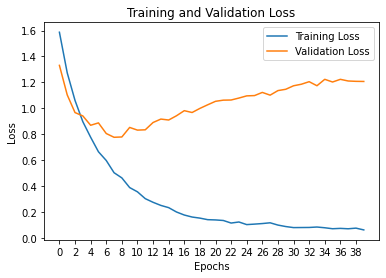

In [12]:
from matplotlib.pylab import plt
from numpy import arange


# Retrieve each dictionary's values
train_values = train_loss_dict.values()
val_values = val_loss_dict.values()

# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)


# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 2))

# Display the plot
plt.legend(loc='best')
plt.show()